**bold text**

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
from wandb.keras import WandbCallback
from tensorflow.keras.optimizers import *
import itertools
import gc
import wandb
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm
from tensorflow import keras
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/HW02-Practical

In [ ]:
dataset_train1 = tf.keras.utils.image_dataset_from_directory('Dataset/train')
dataset_test1 = tf.keras.utils.image_dataset_from_directory('Dataset/test')
dataset_valid1 = tf.keras.utils.image_dataset_from_directory('Dataset/valid')

Found 15021 files belonging to 5 classes.
Found 5116 files belonging to 5 classes.
Found 5010 files belonging to 5 classes.


In [ ]:
# resize
image_size = (28, 28)
dataset_train = dataset_train1.map(lambda x, y: (tf.image.resize(x, image_size), y))
dataset_test = dataset_test1.map(lambda x, y: (tf.image.resize(x, image_size), y))
dataset_valid = dataset_valid1.map(lambda x, y: (tf.image.resize(x, image_size), y))

In [ ]:
img_width, img_height         = 28, 28
batch_size                    = 250
no_epochs                     = 10
no_classes                    = 5
verbosity                     = 1
max_norm_value                = 2.0
input_shape = (img_width  , img_height, 3)

In [ ]:
 #3e51292cfdf8601e6ff1fbb78e560c288e381156

In [ ]:
def train_opt():
    
    
    hyperparams = dict( 
        lr=0.001,
        dropout=0.6,
        batch_size=250,
        epochs=10)
    
    wandb.init(project="HW2-opt", config=hyperparams)
    config = wandb.config
    

    dp = config.dropout         

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dp))
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dp))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value)))
    model.add(Dense(no_classes, activation='softmax'))
    opt = Adam(config.lr)
 
    
    
    model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    # Set callbacks

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1), 
        ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.5, min_lr=1e-4),
        WandbCallback(monitor='val_loss', validation_data=dataset_valid)]  
    
    results = model.fit(dataset_train, 
                     batch_size=config.batch_size,    # BATCH_SIZE, 
                     epochs=config.epochs,            # EPOCHS, 
                     validation_data=dataset_valid, 
                     callbacks=callbacks,
                     verbose=1) 
    
    with open('/content/gdrive/MyDrive/HW02-Practical/results_wandb.pkl', 'wb') as file:
      pickle.dump(results, file)

In [ ]:
sweep_config = {

    'method': 'random',         # 'grid', 'hyperopt', 'bayesian'
    'metric': {
        'name': 'val_loss',     # or 'val_accuracy'
        'goal': 'minimize'      # 'maximize'
    },
    'parameters': {
        
        'lr': {
            'distribution': 'uniform',
            'min': 0.0005,
            'max': 0.002
        },
        'dp': {
            'values': [0.01,0.1,0.4, 0.5]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: wrmys5kh
Sweep URL: https://wandb.ai/mahsaaminiii2222/uncategorized/sweeps/wrmys5kh


In [ ]:
wandb.agent(sweep_id, function=train_opt, count=3)  

wandb: Agent Starting Run: fdsv8c36 with config:
wandb: 	dp: 0.5
wandb: 	lr: 0.0012225868694791997
wandb: Currently logged in as: mahsaaminiii2222. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
469/470 [============================>.] - ETA: 7s - loss: 4.7024 - accuracy: 0.2326 

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.1s


470/470 [==============================] - 5009s 11s/step - loss: 4.6998 - accuracy: 0.2327 - val_loss: 1.6114 - val_accuracy: 0.1996 - lr: 0.0012
Epoch 2/10
470/470 [==============================] - 78s 165ms/step - loss: 1.6057 - accuracy: 0.2526 - val_loss: 1.6143 - val_accuracy: 0.2066 - lr: 0.0012
Epoch 3/10
469/470 [============================>.] - ETA: 0s - loss: 1.5630 - accuracy: 0.3138

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 88s 185ms/step - loss: 1.5629 - accuracy: 0.3140 - val_loss: 1.5788 - val_accuracy: 0.2707 - lr: 0.0012
Epoch 4/10
469/470 [============================>.] - ETA: 0s - loss: 1.4537 - accuracy: 0.3936

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 78s 164ms/step - loss: 1.4536 - accuracy: 0.3936 - val_loss: 1.4489 - val_accuracy: 0.3926 - lr: 0.0012
Epoch 5/10
469/470 [============================>.] - ETA: 0s - loss: 1.2726 - accuracy: 0.4656

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 88s 185ms/step - loss: 1.2726 - accuracy: 0.4654 - val_loss: 1.2931 - val_accuracy: 0.4719 - lr: 0.0012
Epoch 6/10
469/470 [============================>.] - ETA: 0s - loss: 1.2178 - accuracy: 0.4925

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 86s 182ms/step - loss: 1.2180 - accuracy: 0.4922 - val_loss: 1.2082 - val_accuracy: 0.5557 - lr: 0.0012
Epoch 7/10
469/470 [============================>.] - ETA: 0s - loss: 1.0989 - accuracy: 0.5565

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.1s


470/470 [==============================] - 84s 177ms/step - loss: 1.0987 - accuracy: 0.5568 - val_loss: 1.1672 - val_accuracy: 0.5762 - lr: 0.0012
Epoch 8/10
469/470 [============================>.] - ETA: 0s - loss: 1.0414 - accuracy: 0.5890

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.1s


470/470 [==============================] - 86s 181ms/step - loss: 1.0414 - accuracy: 0.5890 - val_loss: 1.1051 - val_accuracy: 0.5950 - lr: 0.0012
Epoch 9/10
469/470 [============================>.] - ETA: 0s - loss: 0.9834 - accuracy: 0.6139

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 92s 195ms/step - loss: 0.9831 - accuracy: 0.6141 - val_loss: 1.0728 - val_accuracy: 0.6279 - lr: 0.0012
Epoch 10/10
469/470 [============================>.] - ETA: 0s - loss: 0.9555 - accuracy: 0.6276

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_203605-fdsv8c36/files/model-best)... Done. 0.0s


470/470 [==============================] - 82s 173ms/step - loss: 0.9556 - accuracy: 0.6273 - val_loss: 1.0717 - val_accuracy: 0.6433 - lr: 0.0012


accuracy,▁▁▂▄▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▅▇▇▇██
val_loss,███▆▄▃▂▁▁▁
accuracy,0.62732
best_epoch,9
best_val_loss,1.07168
epoch,9
loss,0.95558


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gmgu74h5 with config:
wandb: 	dp: 0.5
wandb: 	lr: 0.0011462624035629577
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
469/470 [============================>.] - ETA: 0s - loss: 4.4670 - accuracy: 0.2571

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.0s


470/470 [==============================] - 83s 173ms/step - loss: 4.4644 - accuracy: 0.2571 - val_loss: 1.6134 - val_accuracy: 0.2070 - lr: 0.0011
Epoch 2/10
469/470 [============================>.] - ETA: 0s - loss: 1.5472 - accuracy: 0.3390

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.0s


470/470 [==============================] - 87s 183ms/step - loss: 1.5473 - accuracy: 0.3389 - val_loss: 1.5463 - val_accuracy: 0.3070 - lr: 0.0011
Epoch 3/10
469/470 [============================>.] - ETA: 0s - loss: 1.4324 - accuracy: 0.4005

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.1s


470/470 [==============================] - 90s 191ms/step - loss: 1.4324 - accuracy: 0.4005 - val_loss: 1.3512 - val_accuracy: 0.4269 - lr: 0.0011
Epoch 4/10
469/470 [============================>.] - ETA: 0s - loss: 1.3028 - accuracy: 0.4471

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.1s


470/470 [==============================] - 87s 183ms/step - loss: 1.3027 - accuracy: 0.4472 - val_loss: 1.2852 - val_accuracy: 0.4737 - lr: 0.0011
Epoch 5/10
469/470 [============================>.] - ETA: 0s - loss: 1.2518 - accuracy: 0.4699

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.1s


470/470 [==============================] - 92s 194ms/step - loss: 1.2517 - accuracy: 0.4699 - val_loss: 1.2385 - val_accuracy: 0.4367 - lr: 0.0011
Epoch 6/10
469/470 [============================>.] - ETA: 0s - loss: 1.2115 - accuracy: 0.4959

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.0s


470/470 [==============================] - 82s 172ms/step - loss: 1.2112 - accuracy: 0.4960 - val_loss: 1.2333 - val_accuracy: 0.5088 - lr: 0.0011
Epoch 7/10
469/470 [============================>.] - ETA: 0s - loss: 1.0884 - accuracy: 0.5687

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.0s


470/470 [==============================] - 93s 196ms/step - loss: 1.0881 - accuracy: 0.5689 - val_loss: 1.0556 - val_accuracy: 0.6146 - lr: 0.0011
Epoch 8/10
470/470 [==============================] - 87s 182ms/step - loss: 0.9826 - accuracy: 0.6150 - val_loss: 1.0633 - val_accuracy: 0.6275 - lr: 0.0011
Epoch 9/10
469/470 [============================>.] - ETA: 0s - loss: 0.9371 - accuracy: 0.6397

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.1s


470/470 [==============================] - 90s 190ms/step - loss: 0.9371 - accuracy: 0.6397 - val_loss: 0.9834 - val_accuracy: 0.6439 - lr: 0.0011
Epoch 10/10
470/470 [==============================] - ETA: 0s - loss: 0.8836 - accuracy: 0.6598

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_221531-gmgu74h5/files/model-best)... Done. 0.1s


470/470 [==============================] - 82s 172ms/step - loss: 0.8836 - accuracy: 0.6598 - val_loss: 0.9559 - val_accuracy: 0.6820 - lr: 0.0011


accuracy,▁▂▃▄▅▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▂▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▄▅▇▇▇█
val_loss,█▇▅▅▄▄▂▂▁▁
accuracy,0.65981
best_epoch,9
best_val_loss,0.95589
epoch,9
loss,0.88355


wandb: Agent Starting Run: abcqcyys with config:
wandb: 	dp: 0.1
wandb: 	lr: 0.0018673447502163805
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
470/470 [==============================] - ETA: 0s - loss: 4.6393 - accuracy: 0.2064

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.1s


470/470 [==============================] - 91s 190ms/step - loss: 4.6393 - accuracy: 0.2064 - val_loss: 1.6098 - val_accuracy: 0.1996 - lr: 0.0019
Epoch 2/10
470/470 [==============================] - 88s 185ms/step - loss: 1.6064 - accuracy: 0.2345 - val_loss: 1.6112 - val_accuracy: 0.1998 - lr: 0.0019
Epoch 3/10
470/470 [==============================] - 87s 184ms/step - loss: 1.6006 - accuracy: 0.2498 - val_loss: 1.6127 - val_accuracy: 0.2008 - lr: 0.0019
Epoch 4/10
470/470 [==============================] - 90s 188ms/step - loss: 1.6005 - accuracy: 0.2521 - val_loss: 1.6140 - val_accuracy: 0.2014 - lr: 0.0019
Epoch 5/10
469/470 [============================>.] - ETA: 0s - loss: 1.5839 - accuracy: 0.2923

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.1s


470/470 [==============================] - 89s 187ms/step - loss: 1.5839 - accuracy: 0.2924 - val_loss: 1.6058 - val_accuracy: 0.2301 - lr: 0.0019
Epoch 6/10
469/470 [============================>.] - ETA: 0s - loss: 1.4224 - accuracy: 0.4156

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.1s


470/470 [==============================] - 91s 193ms/step - loss: 1.4224 - accuracy: 0.4158 - val_loss: 1.3115 - val_accuracy: 0.4822 - lr: 0.0019
Epoch 7/10
469/470 [============================>.] - ETA: 0s - loss: 1.1268 - accuracy: 0.5504

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.1s


470/470 [==============================] - 95s 199ms/step - loss: 1.1267 - accuracy: 0.5504 - val_loss: 1.1943 - val_accuracy: 0.5806 - lr: 0.0019
Epoch 8/10
470/470 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.5932

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.0s


470/470 [==============================] - 90s 191ms/step - loss: 1.0376 - accuracy: 0.5932 - val_loss: 1.1779 - val_accuracy: 0.5842 - lr: 0.0019
Epoch 9/10
469/470 [============================>.] - ETA: 0s - loss: 0.9810 - accuracy: 0.6184

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.1s


470/470 [==============================] - 90s 190ms/step - loss: 0.9812 - accuracy: 0.6182 - val_loss: 1.1460 - val_accuracy: 0.5924 - lr: 0.0019
Epoch 10/10
469/470 [============================>.] - ETA: 0s - loss: 0.9371 - accuracy: 0.6366

wandb: Adding directory to artifact (/content/gdrive/MyDrive/HW02-Practical/wandb/run-20230526_223408-abcqcyys/files/model-best)... Done. 0.0s


470/470 [==============================] - 94s 198ms/step - loss: 0.9370 - accuracy: 0.6366 - val_loss: 1.0586 - val_accuracy: 0.6864 - lr: 0.0019


accuracy,▁▁▂▂▂▄▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▂▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▅▆▇▇█
val_loss,█████▄▃▃▂▁
accuracy,0.63658
best_epoch,9
best_val_loss,1.05862
epoch,9
loss,0.93699


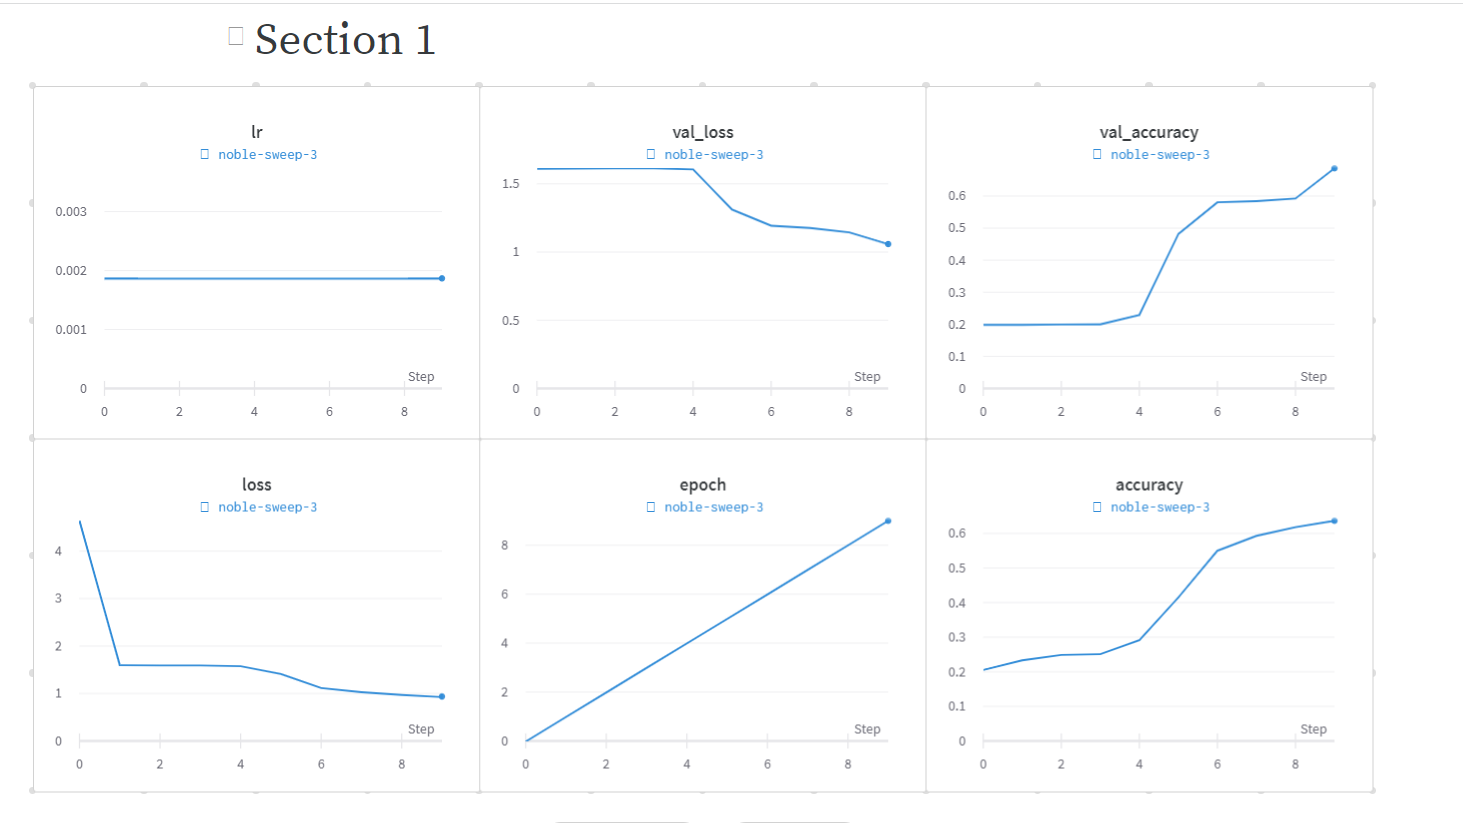